# 04-Identifying Fraudulent Activities

**Tasks:**
1. For each user, determine her country based on the numeric IP address.
1. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
1. Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
1. Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is,
1. what kind of different user experiences would you build based on the model output?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import graphviz

In [2]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,roc_curve
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [4]:
data = pd.read_csv('./datasets/04-IdentifyingFraudulentActivities/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
address2country = pd.read_csv('./datasets/04-IdentifyingFraudulentActivities/IpAddress_to_Country.csv')

In [5]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [7]:
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [8]:
print('Variable', '   ', 'Count of unique value','  ', 'content')
for column in data.columns:
    uniques = data[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:3])

Variable     Count of unique value    content
user_id              151112	 [ 22058 333320   1359]
signup_time          151112	 ['2015-02-24T22:55:49.000000000' '2015-06-07T20:39:50.000000000'
 '2015-01-01T18:52:44.000000000']
purchase_time        150679	 ['2015-04-18T02:47:11.000000000' '2015-06-08T01:38:54.000000000'
 '2015-01-01T18:52:45.000000000']
purchase_value        122	 [34 16 15]
device_id            137956	 ['QVPSPJUOCKZAR' 'EOGFQPIZPYXFZ' 'YSSKYOSJHPPLJ']
source                  3	 ['SEO' 'Ads' 'Direct']
browser                 5	 ['Chrome' 'Opera' 'Safari']
sex                     2	 ['M' 'F']
age                    58	 [39 53 41]
ip_address           143512	 [7.32758369e+08 3.50311388e+08 2.62147382e+09]
class                   2	 [0 1]


In [9]:
# Check uniqueness
#print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))
print('Unique User Ids:\t', len(data['user_id'].unique()),'\t',
      len(data['user_id'].unique())==len(data['user_id']) )

Unique User Ids:	 151112 	 True


Conclusion: No replicated data

In [10]:
# Null information
data.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [11]:
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [12]:
print('Variable', '   ', 'Count of unique value','  ', 'content')
for column in address2country.columns:
    uniques = address2country[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:5])

Variable     Count of unique value    content
lower_bound_ip_address 138846	 [16777216. 16777472. 16777728. 16778240. 16779264.]
upper_bound_ip_address 138846	 [16777471 16777727 16778239 16779263 16781311]
country               235	 ['Australia' 'China' 'Japan' 'Thailand' 'India']


## 1. Add Country to Dataset

In [13]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = address2country[(address2country['lower_bound_ip_address'] <= ip_address) &
                          (address2country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')

In [14]:
data['country'] = countries
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## 2. Feature Engineering

1. Time difference between sign-up time and purchase time
1. If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
1. Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
1. Usual week of the year and day of the week from time variables

In [15]:
# Get the time difference between purchase time and signup time
time_diff = data['purchase_time'] - data['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
data['time_diff'] = time_diff

In [16]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461


In [17]:
# Check user number for unique devices
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
data = data.merge(device_num, how='left', on='device_id')

In [18]:
# Check user number for unique ip_address
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

In [19]:
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


In [20]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [21]:
# Label encoder
le = LabelEncoder()
data_new = data[['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'age', 'time_diff', 'device_num', 'ip_num']]
data_new['source'] = le.fit_transform(data['source'])
data_new['browser'] = le.fit_transform(data['browser'])
data_new['sex'] = le.fit_transform(data['sex'])
data_new['country'] = le.fit_transform(data['country'])

/Users/Qinmeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/Qinmeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Qinmeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [22]:
data.rename(columns={'class':'is_fraud'},inplace=True)# 'class' is a reserved keyword
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,is_fraud
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


In [23]:
data.to_csv("./fraud_cleaned.csv")

## 3. Fraudulent Activity Identification

In [24]:
seed = 999
X = data_new.loc[:,data_new.columns != 'is_fraud']
y = data.is_fraud

# split into training dataset and test dataset
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

Use cross-validation to find best number of trees

In [25]:
params = {}
params['silent'] = 1
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[22:47:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:47:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:47:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in

In [26]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.843966,0.000968,0.843720,0.003691
1,0.844030,0.000969,0.843673,0.003732
2,0.844134,0.000977,0.843707,0.003689
3,0.844239,0.000934,0.843620,0.003649
4,0.844315,0.000991,0.843585,0.003682
5,0.844762,0.001441,0.844528,0.003128
6,0.844927,0.001406,0.844540,0.003185
7,0.848414,0.001837,0.843864,0.002718
8,0.848546,0.001963,0.843861,0.002770
9,0.849553,0.001817,0.843781,0.002909


In [27]:
n_best_trees = cv_results.shape[0]
n_best_trees

16

In [28]:
# retrain on the whole training dataset
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[22:47:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.84398
[1]	train-auc:0.84406
[2]	train-auc:0.84418
[3]	train-auc:0.84425
[4]	train-auc:0.84427
[5]	train-auc:0.84433
[6]	train-auc:0.84431
[7]	train-auc:0.84435
[8]	train-auc:0.85006
[9]	train-auc:0.85487
[10]	train-auc:0.85672
[11]	train-auc:0.85636
[12]	train-auc:0.85721
[13]	train-auc:0.85809
[14]	train-auc:0.85978
[15]	train-auc:0.86042


## Plot ROC and choose threshold

In [29]:
def plot_validation_roc():
    """
    we cannot plot ROC on either training set or test set, since both are biased
    so I split the training dataset again into training set and validation set
    retrain on training set and plot ROC on validation set and choose a proper cutoff value
    
    define a class to limit the naming group, avoid polluting the global naming space
    """
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.3,random_state=seed)
    onlytrain_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid,yvalid)

    temp_gbt = xgb.train(params, onlytrain_matrix, n_best_trees,[(onlytrain_matrix,'train_only'),(valid_matrix,'validate')])
    yvalid_proba_pred = temp_gbt.predict(valid_matrix,ntree_limit=n_best_trees)

    fpr,tpr,thresholds = roc_curve(yvalid,yvalid_proba_pred)
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

In [30]:
roc = plot_validation_roc()

[22:48:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { early_stopping_rounds, num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train_only-auc:0.84376	validate-auc:0.84456
[1]	train_only-auc:0.84391	validate-auc:0.84445
[2]	train_only-auc:0.84397	validate-auc:0.84436
[3]	train_only-auc:0.84407	validate-auc:0.84431
[4]	train_only-auc:0.84437	validate-auc:0.84428
[5]	train_only-auc:0.84443	validate-auc:0.84424
[6]	train_only-auc:0.84776	validate-auc:0.84791
[7]	train_only-auc:0.84784	validate-auc:0.84787
[8]	train_only-auc:0.84982	validate-auc:0.84722
[9]	train_only-auc:0.84997	validate-auc:0.84767
[10]	train_only-auc:0.84999	validate-auc:0.84762
[11]	train_only-auc:0.85101	validate-auc:0.84794
[12]	train_only-auc:0.85264	val

Text(0, 0.5, 'TPR')

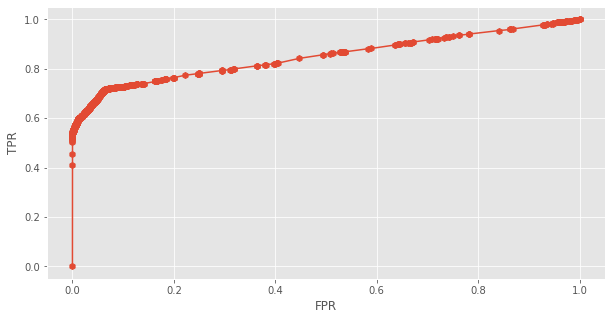

In [31]:
plt.figure(figsize=(10,5))
plt.plot(roc.FPR,roc.TPR,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")

## Impact of FP vs. FN

* if false positive cost much higher, we should increase the probability threshold, but pay the price TPR is also decreased.
* if false negative cost much higher, we should decrease the probability threshold, but pay the price FPR is also increased.

In [32]:
roc.loc[ (roc.TPR >= 0.78) & (roc.TPR <=0.83),:]

,FPR,TPR,Threshold
1128,0.247100,0.780343,0.122890
1129,0.247307,0.780343,0.122876
1130,0.248346,0.780343,0.122859
1131,0.248416,0.780343,0.122840
1132,0.249593,0.780693,0.122840
1133,0.249766,0.780693,0.122840
1134,0.249801,0.780693,0.122837
1135,0.250147,0.781042,0.122836
1136,0.250182,0.781042,0.122834
1137,0.250251,0.781042,0.122832


in this case, because normally this "Fraud Detection Model" is often used in a pre-screening step, whose result will be further investigated by expert, so
* if 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem
* but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.
so in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.

## 4: Explain features

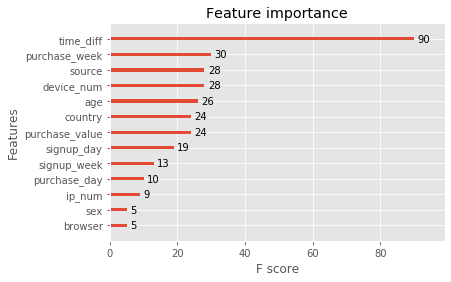

In [33]:
# first we plot the feature importance from GBM
xgb.plot_importance(gbt)

from above model, we can see that, 'interval_after_signup' is the most important factor helping us to decide a transaction is fraud or not.

To better understand, we fit a shallow, simple Decision Tree and plot it.

In [34]:
dt = DecisionTreeClassifier(max_depth=3,min_samples_leaf=20,min_samples_split=20)
dt.fit(X,y)
dot_data = export_graphviz(dt,feature_names=X.columns,class_names=['NotFraud','Fraud'],
                proportion=True,leaves_parallel=True,filled=True)

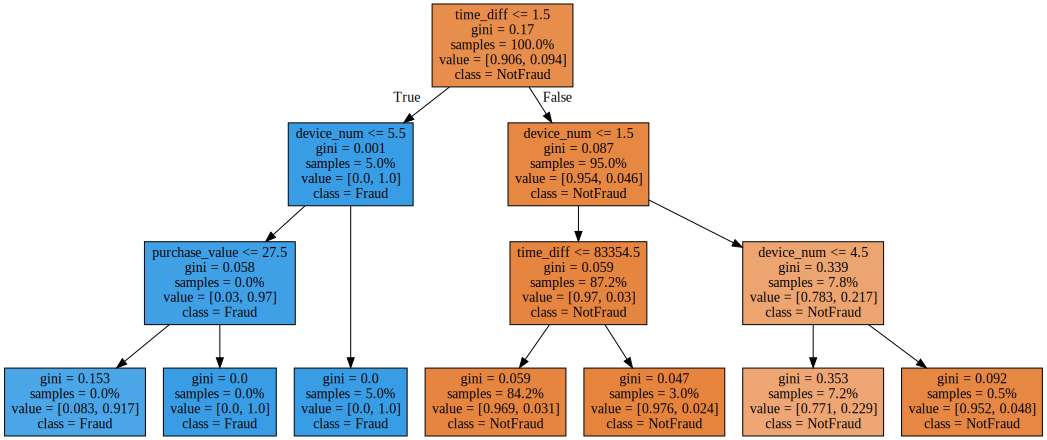

In [35]:
graph = graphviz.Source(dot_data)
graph

from above plot, we focus on two leaf-nodes

* the blue leaf node indicates, if 'interval_after_signup' is <=1.5 seconds, which means the customer purchases immediatelly after signup, then there is very high probability that this transaction is fraud.
* the leaf-node with positive ratio=23% (the second node from right), if the purchase is from a device shared by 2~5 users, then there is above-normal probability that the transaction is fraud.

## 5. How to use the model?

since my model can predict the probability a purchase is fraud, so I need to set two probability cutoffs as 'alert value', alert1 and alert2, and alert1 < alert2 .

for a incoming purchase, my model will return the probability 'p' that the purchase is fraud,

* if p < alert1, then I assume the purchase is normal, proceed without any problem
* if alert1 <= p < alert2, then I assume the purchase is suspicious, I will ask the customer for additional authroization. for example, send email or SMS to the customer, let him/her authorize the purchase.
* if p>= alert2, then the purchase is highly suspicious, I not only ask the customer for additional authorization via email or SMS, but also put the purchase on hold and send the purchase information to some human expert for further investigation.

**References:**
1. https://github.com/stasi009/TakeHomeDataChallenges/blob/master/04.FraudActivity/fraud_activity.ipynb
2. https://github.com/JifuZhao/DS-Take-Home/blob/master/04.%20Identifying%20Fraudulent%20Activities.ipynb